<a href="https://colab.research.google.com/github/hadwin-357/ML_models/blob/main/gaussian_process_gpytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
!pip install gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.6 MB/s eta 0:00:00


In [25]:
train_x = torch.linspace(-1,1, 100) # 100 point between 0 and 1
train_y = torch.sigmoid(train_x*(2*math.pi)) + torch.randn(train_x.size())*math.sqrt(0.04) # value + noise


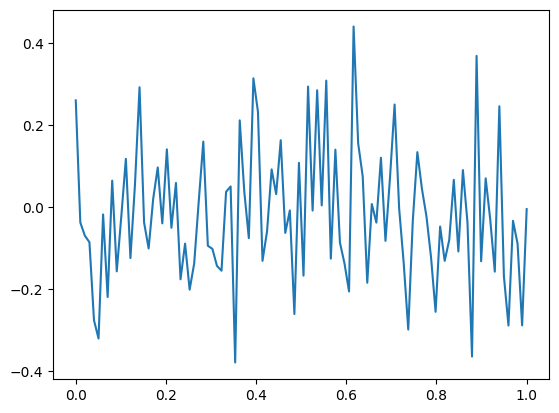

In [ ]:
plt.plot( train_x, torch.randn(train_x.size())*math.sqrt(0.04))

In [26]:
class ExactGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super(ExactGPModel,self).__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

  def forward(self,x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [9]:
print(model)
for name, param in model.named_parameters():
    print(name, param.data)


ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)
likelihood.noise_covar.raw_noise tensor([0.])
mean_module.raw_constant tensor(0.)
covar_module.raw_outputscale tensor(0.)
covar_module.base_kernel.raw_lengthscale tensor([[0.]])


In [10]:
import os
smoke_test =('CI' in os.environ)

In [27]:
training_iter = 2 if smoke_test else 50

#find optimal model hyperparametesrs
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# loss for GP
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
  optimizer.zero_grad()
  output = model(train_x)
  loss = -mll(output, train_y)
  loss.backward()
  #loss.backward()
  print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
      i + 1, training_iter, loss.item(),
      model.covar_module.base_kernel.lengthscale.item(),
      model.likelihood.noise.item()
  ))
  optimizer.step()

Iter 1/50 - Loss: 0.824   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.788   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.751   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 0.715   lengthscale: 0.851   noise: 0.554
Iter 5/50 - Loss: 0.679   lengthscale: 0.902   noise: 0.513
Iter 6/50 - Loss: 0.643   lengthscale: 0.950   noise: 0.474
Iter 7/50 - Loss: 0.607   lengthscale: 0.990   noise: 0.437
Iter 8/50 - Loss: 0.571   lengthscale: 1.021   noise: 0.403
Iter 9/50 - Loss: 0.535   lengthscale: 1.040   noise: 0.371
Iter 10/50 - Loss: 0.499   lengthscale: 1.046   noise: 0.340
Iter 11/50 - Loss: 0.463   lengthscale: 1.041   noise: 0.312
Iter 12/50 - Loss: 0.426   lengthscale: 1.025   noise: 0.286
Iter 13/50 - Loss: 0.389   lengthscale: 1.000   noise: 0.262
Iter 14/50 - Loss: 0.352   lengthscale: 0.968   noise: 0.240
Iter 15/50 - Loss: 0.315   lengthscale: 0.930   noise: 0.219
Iter 16/50 - Loss: 0.279   lengthscale: 0.889   noise: 0.200
Iter 17/50 - Loss: 0.243   length

In [28]:
for name, param in model.named_parameters():
    print(name, param.data)

likelihood.noise_covar.raw_noise tensor([-3.4484])
mean_module.raw_constant tensor(0.5670)
covar_module.raw_outputscale tensor(-1.4388)
covar_module.base_kernel.raw_lengthscale tensor([[0.0065]])


In [15]:
test_x = torch.linspace(0, 1, 51)
model.eval()
likelihood.eval()

f_preds = model(test_x)

y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_covar.shape
f_mean
#f_samples = f_preds.sample(sample_shape=torch.Size(1000,))


tensor([ 0.0500,  0.1417,  0.2378,  0.3366,  0.4362,  0.5345,  0.6295,  0.7189,
         0.8007,  0.8727,  0.9330,  0.9798,  1.0117,  1.0276,  1.0266,  1.0084,
         0.9729,  0.9207,  0.8525,  0.7696,  0.6734,  0.5658,  0.4489,  0.3249,
         0.1961,  0.0649, -0.0663, -0.1953, -0.3198, -0.4380, -0.5478, -0.6478,
        -0.7364, -0.8125, -0.8751, -0.9234, -0.9569, -0.9752, -0.9781, -0.9658,
        -0.9384, -0.8963, -0.8403, -0.7712, -0.6901, -0.5981, -0.4968, -0.3877,
        -0.2727, -0.1536, -0.0323], grad_fn=<ViewBackward0>)

In [29]:
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-1, 1, 51)
    observed_pred = likelihood(model(test_x))

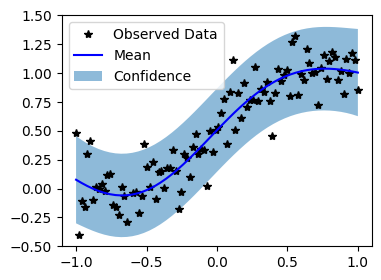

In [31]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-0.5, 1.5])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])